In [1]:
import math    # sqrt
import imageio # imread, imwrite
import imutils # image rotate bounds
import skimage # noise

## `im_split`
Takes an image `im` and optionally a parameter `blocks` to determine how many blocks it should be split into. `blocks` must be a square number greater than 1. Overlap determines the percentage overlap between the blocks, for example, if `p=0.2` 20% of an image will be common with its neighboring image.

In [2]:
def im_split(im, overlap=0.2, blocks=4, rotation=0, noise=0):
    assert(blocks > 1)
    assert(math.sqrt(blocks).is_integer())
    assert(overlap >= 0 and overlap < 1)
    
    rows = int(math.sqrt(blocks))
    width = im.shape[0]
    height = im.shape[1]
    
    offset_w = (width / rows * overlap/2)
    output_w = (width / rows) + offset_w
    
    offset_h = (height / rows * overlap/2)
    output_h = (height / rows) + offset_h
    
    output_images = []
    
    for r in range(rows):
        r_start = int(max(output_w * r - offset_w * (r+1), 0))
        r_end   = int(min(output_w * (r+1), height))
        for c in range(rows):
            c_start = int(max(output_h * c - offset_h * (c+1), 0))
            c_end   = int(min(output_h * (c+1), width))
            # print("%d:%d , %d:%d" % (r_start, r_end, c_start, c_end))
            block = im[r_start:r_end,c_start:c_end]
            # Do not transform the first block.
            if r+c == 0:
                output_images.append(block)
                continue
            if noise > 0:
                mean = 0.0
                std = noise
                block = skimage.util.random_noise(block, mode='gaussian', mean=mean, var=std)
                block *= (2**16)-1               # scale pixels back to 0..65535
                block = block.astype('uint16')   # cast back to uint16
            if rotation > 0:
                block = imutils.rotate_bound(block, rotation)
                
            output_images.append(block)
    
    return output_images

## Test

In [3]:
# fname = 'S2_Img_003.00.tif'
fname = 'T1_Img_002.00.tif'
im1 = imageio.imread('../data/%s' % fname)

# split parameters, used later for plotting
blocks = 4
overlap = 0.25
imgs_no_rot    = im_split(im1, blocks=blocks, overlap=overlap)
imgs_noise     = im_split(im1, blocks=blocks, overlap=overlap,                noise=0.1)
imgs_rot       = im_split(im1, blocks=blocks, overlap=overlap, rotation=25)
imgs_rot_noise = im_split(im1, blocks=blocks, overlap=overlap, rotation=35, noise=0.01)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def plot_blocks(imgs, bars=False):
    fig = plt.figure(figsize=(9, 8), dpi=72)
    rows = int(math.sqrt(blocks))
    for i in range(1, len(imgs)+1):
        fig.add_subplot(rows, rows, i)
        plt.imshow(imgs[i-1], cmap=plt.cm.gray)
        if bars:
            # left
            axs = plt.gca()
            ax,ay = (imgs[i-1].shape[0] * overlap, 0)
            bx,by = (imgs[i-1].shape[0] * overlap, imgs[i-1].shape[1])
            l = mlines.Line2D([ax, bx], 
                              [ay, by], color='r')
            axs.add_line(l)
            # right
            ax,ay = (imgs[i-1].shape[0] * (1-overlap), 0)
            bx,by = (imgs[i-1].shape[0] * (1-overlap), imgs[i-1].shape[1])
            l = mlines.Line2D([ax, bx], 
                              [ay, by], color='r')
            axs.add_line(l)
            # top
            ax,ay = (0, imgs[i-1].shape[1] * overlap)
            bx,by = (imgs[i-1].shape[1], imgs[i-1].shape[0] * overlap)
            l = mlines.Line2D([ax, bx], 
                              [ay, by], color='r')
            axs.add_line(l)
            # bottom
            ax,ay = (0, imgs[i-1].shape[1] * (1-overlap))
            bx,by = (imgs[i-1].shape[1], imgs[i-1].shape[0] * (1-overlap))
            l = mlines.Line2D([ax, bx], 
                              [ay, by], color='r')
            axs.add_line(l)
    plt.show()

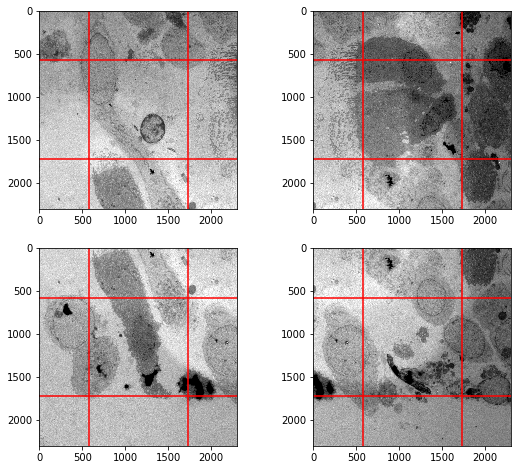

In [5]:
plot_blocks(imgs_no_rot, bars=True)

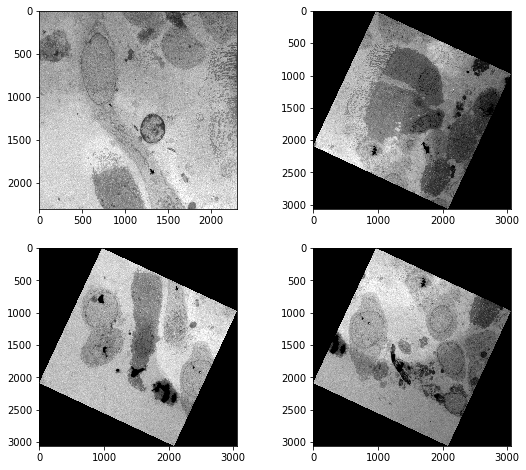

In [6]:
plot_blocks(imgs_rot)

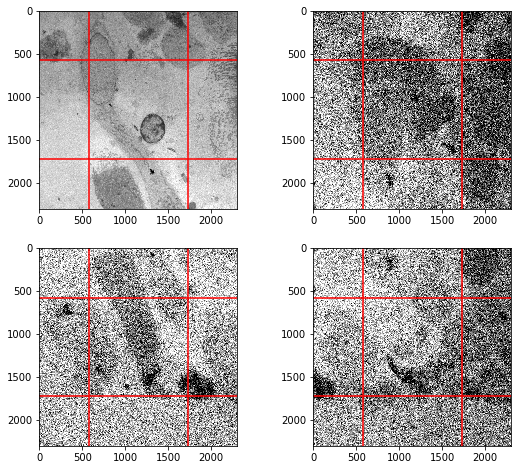

In [7]:
# plot_blocks(imgs_rot_noise)
plot_blocks(imgs_noise, bars=True)

In [8]:
def write_ims(ims, prefix, rotation=False, noise=False):
    flags = ''
    if rotation:
        flags += '_rot'
    if noise:
        flags += '_noise'
    for (ind, im) in enumerate(ims):
        imageio.imwrite('../data/%s_segment%s_%d.tif' % (prefix, flags, ind+1), im[:, :])

In [9]:
write_ims(imgs_no_rot, fname.split('_')[0])
write_ims(imgs_noise, fname.split('_')[0], noise=True)
write_ims(imgs_rot, fname.split('_')[0], rotation=True)
write_ims(imgs_rot_noise, fname.split('_')[0], rotation=True, noise=True)